# Analyzing Aggravated Burglaries in Davidson County

In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from IPython.display import Image
import json
import geopandas as gpd
from io import StringIO
import statsmodels.api as sm

1. A dataset containing details about Metro Nashville Police Department reported incidents is available at https://data.nashville.gov/Police/Metro-Nashville-Police-Department-Incidents/2u6v-ujjs. Make use of the API to find all aggravated burglary incidents that were reported during the six month period from January 1, 2021 through June 30, 2021.

In [81]:
# fetch the GeoJson data from Jan. to Jun. in 2019 from API
endpoint = 'https://data.nashville.gov/resource/2u6v-ujjs.geojson'
params = {
    'offense_description':'BURGLARY- AGGRAVATED',
    '$where':'incident_occurred between \'2021-01-01\' and \'2021-06-30\'',
    '$limit':2000
    }
response = requests.get(endpoint, params = params)

# load the GeoJson data in a GeoPandas dataframe
agg_burg = gpd.read_file(StringIO(response.text))

# drop duplicate rows with the same incident_number
agg_burg=agg_burg.drop_duplicates(subset = ['incident_number'])

2. Download the 2019 census tract shapefiles for Tennessee from https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.2019.html. (The FIPS code for Tennessee is 47). Perform a spatial join to determine the census tract in which each burglary incident occurred. Which census tract had the highest number of burglaries? Warning - each incident can appear multiple times if there are multiple victims, so be sure that you aren't double-counting any incidents.

In [82]:
# load the data to a GeoPandas dataframe census_tract
census_tract=gpd.read_file('../data/tl_2019_47_tract/')

# convert the EPSG to 4326
census_tract = census_tract.to_crs('EPSG:4326')

# spatial join census_tract with agg_burg
burg_census = gpd.sjoin(agg_burg, census_tract,how='left', op = 'within')

# find the census tract with the highest number of burglaries
burg_census['NAMELSAD'].value_counts().index[0]

'Census Tract 163'

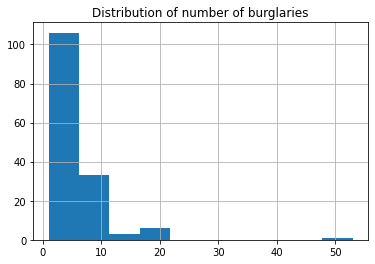

In [121]:
burg_census['NAMELSAD'].value_counts().hist()
plt.title('Distribution of number of burglaries');


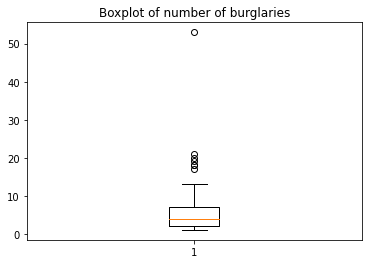

In [122]:
plt.boxplot(burg_census['NAMELSAD'].value_counts())
plt.title('Boxplot of number of burglaries');


3. For this part, you'll need to request a census API key. Using the 2019 American Community Survey API, obtain, for each census tract, the population (B01001_001E in the detailed tables) and the median income (S1901_C01_012E in the subject tables). Hint: Tennessee's FIPS code is 47 and Davidson County's FIPS code is 37. Merge this new data with the burglaries data above.

In [83]:
# save the API key to a varable

with open('../data/census.json') as fi:
    credentials = json.load(fi)
api_key = credentials['api_key']

# fetch the data of population in the detailed tables from the API
endpoint = 'https://api.census.gov/data/2019/acs/acs5'
params = {
          'get': 'NAME,B01001_001E',
          'for':'tract:*',
          'in' : ['state:47', 'county:037'],
          'key':api_key
        }
response = requests.get(endpoint, params = params)

# load the JSON data to a Pandas dataframe pop
pop=pd.read_json(response.text)

# delete the first row with column names and rename columns
pop = pop[1:].rename(columns = {0:"name", 1:"population",2:'state',3:'county', 4:'track'})

In [84]:
# fetch the data of median income in the subject tables from the API
endpoint = 'https://api.census.gov/data/2019/acs/acs5/subject'
params = {
          'get': 'NAME,S1901_C01_012E',
          'for':'tract:*',
          'in' : ['state:47', 'county:037'],
          'key':api_key
        }
response = requests.get(endpoint, params = params)

# load the JSON data to a Pandas dataframe median_income
median_income = pd.read_json(response.text)

# delete the first row with column names and rename columns
median_income=median_income[1:].rename(columns = {0:"name", 1:"median_income",2:'state',3:'county', 4:'track'})

In [85]:
# merge pop with median_income on name column
pop_income = pd.merge(pop,median_income, on = 'name')

# extract the Census Track from the name column of pop_income dataframe and save it to a new column NAMELSAD
pop_income['NAMELSAD']=pop_income['name'].apply(lambda x :x.split(',')[0])

# merge burg_census with pop_income on NAMELSAD column
burg_pop_income = pd.merge(burg_census,pop_income, on = 'NAMELSAD')

4. Create a choropleth showing the number of burglaries per 1000 residents for each census tract.

In [86]:
# calculate the number of burglaries in each census track and save it to a Pandas dataframe burg_census_sum
burg_census_sum = (pd.DataFrame(burg_pop_income['NAMELSAD'].value_counts())
                   .reset_index()
                  .rename(columns={'NAMELSAD':'burg_sum','index':'NAMELSAD'}))

# census tracks in Davison county, TN
census_tract_davison = census_tract[census_tract['COUNTYFP']=='037']

# left join burg_census_sum to census_tract_davison on NAMELSAD column. 
# Note: some of the census tracks have zero burglary. Fill the Nan value in the burg_sum column with zero.
burg_census_merged = (pd.merge(census_tract_davison,burg_census_sum, on = 'NAMELSAD', how= 'left')
    .fillna(value={'burg_sum':0}))

# merge burg_census_merged with pop_income
burg_census_pop_income=pd.merge(left = burg_census_merged,
                         right = pop_income,
                        on = 'NAMELSAD')

# change the data type of population and median_income columns to int64
burg_census_pop_income = burg_census_pop_income.astype({'population':'int64', 'median_income':'int64'})

# calculate burglaries per 1000 residents and save it to a new column burg_rate
burg_census_pop_income['burg_rate']= burg_census_pop_income['burg_sum']/burg_census_pop_income['population']*1000

# delete four census tracks with the negative mediam incomes
burg_census_pop_income = burg_census_pop_income.sort_values('median_income')[4:]

,ALAND,AWATER,burg_sum,population,median_income,burg_rate
ALAND,1.000000,0.259097,-0.093759,0.179180,0.174411,-0.133286
AWATER,0.259097,1.000000,-0.012793,0.383443,0.029309,-0.070968
burg_sum,-0.093759,-0.012793,1.000000,0.098654,-0.306596,0.884315
population,0.179180,0.383443,0.098654,1.000000,0.035591,-0.228849
median_income,0.174411,0.029309,-0.306596,0.035591,1.000000,-0.283855
burg_rate,-0.133286,-0.070968,0.884315,-0.228849,-0.283855,1.000000


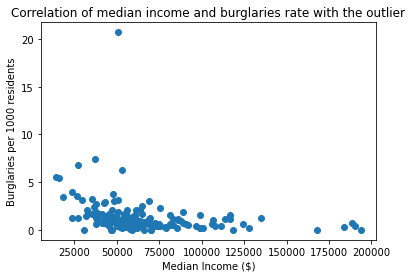

In [124]:
# scatter plot with the outlier
plt.scatter(burg_census_pop_income['median_income'], burg_census_pop_income['burg_rate'])
plt.title('Correlation of median income and burglaries rate with the outlier')
plt.xlabel('Median Income ($)')
plt.ylabel('Burglaries per 1000 residents');

# correlation with the outlier
burg_census_pop_income.corr()

,ALAND,AWATER,burg_sum,population,median_income,burg_rate
ALAND,1.000000,0.258609,-0.089900,0.176588,0.173150,-0.160897
AWATER,0.258609,1.000000,-0.000403,0.383275,0.028666,-0.090573
burg_sum,-0.089900,-0.000403,1.000000,0.212223,-0.388351,0.764883
population,0.176588,0.383275,0.212223,1.000000,0.032801,-0.266999
median_income,0.173150,0.028666,-0.388351,0.032801,1.000000,-0.406925
burg_rate,-0.160897,-0.090573,0.764883,-0.266999,-0.406925,1.000000


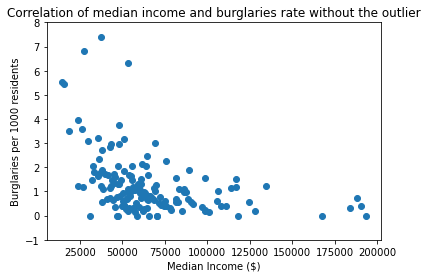

In [125]:
# scatter plot without outlier
plt.scatter(burg_census_pop_income['median_income'], burg_census_pop_income['burg_rate'])
plt.ylim(-1,8)
plt.title('Correlation of median income and burglaries rate without the outlier')
plt.xlabel('Median Income ($)')
plt.ylabel('Burglaries per 1000 residents');

# correlation without outlier
burg_census_pop_income[burg_census_pop_income['burg_rate']<20].corr()

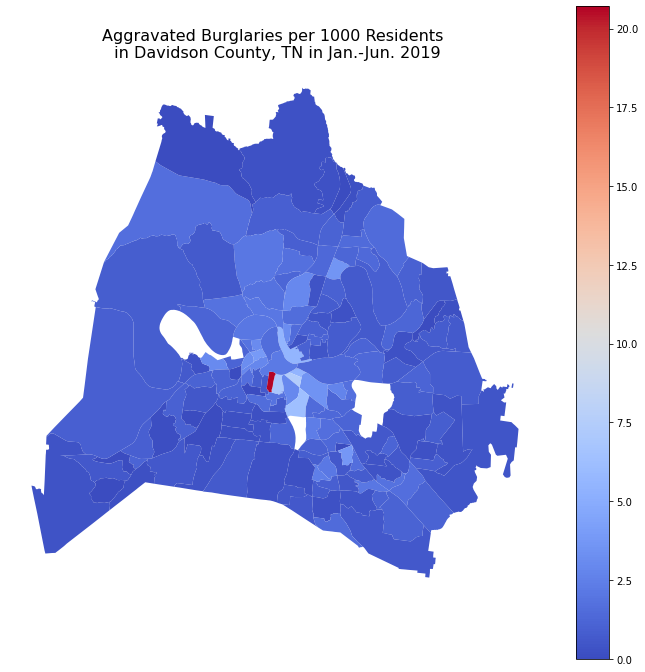

In [87]:
# create a choropleth for burglaries per 1000 residents
fig,ax = plt.subplots(figsize = (12,12))
burg_census_pop_income.plot(column = 'burg_rate',
                            cmap = 'coolwarm', 
                            legend = True,
                           ax = ax)
ax.axis('off')
plt.title('Aggravated Burglaries per 1000 Residents \n in Davidson County, TN in Jan.-Jun. 2019', fontsize = 16);

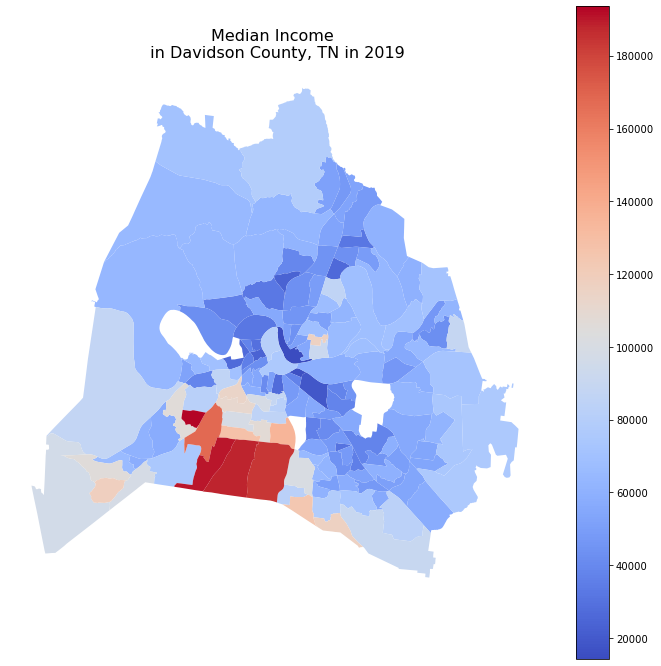

In [127]:
# create a choropleth for burglaries per 1000 residents
fig,ax = plt.subplots(figsize = (12,12))
burg_census_pop_income.plot(column = 'median_income',
                            cmap = 'coolwarm', 
                            legend = True,
                           ax = ax)
ax.axis('off')
plt.title('Median Income \n in Davidson County, TN in 2019', fontsize = 16);

5. Finally, we'll build some statistical models to see how well we can explain the number of aggravated burglaries using the median income of each census tract. For this, we'll be using the Generalized Linear Models module of the statsmodels library.

a. Build a "base model" - a Poisson regression model with just an intercept term with target variable the rate of burglaries per census tract. (Offset using the [log of the] population so that we are looking at the rate of burglaries per population instead of the number of burglaries.)

In [116]:
# base model with an offset of log(population)
base_model = (sm.GLM(endog = burg_census_pop_income['burg_sum'],
    exog = sm.add_constant(burg_census_pop_income[[]]),
    family = sm.families.Poisson(),
    offset = np.log(burg_census_pop_income['population']/1000))
    .fit()
)
base_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               burg_sum   No. Observations:                  157
Model:                            GLM   Df Residuals:                      156
Model Family:                 Poisson   Df Model:                            0
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -598.90
Date:                Mon, 11 Oct 2021   Deviance:                       714.09
Time:                        20:38:35   Pearson chi2:                 1.42e+03
No. Iterations:                     5   Pseudo R-squ. (CS):          1.443e-15
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1753      0.035      5.008      0.000       0.107       0.244
==============================================================================
"""

b. Now, build a Poisson regression model with target variable the rate of burglaries and predictor variable the median income. (Don't forget to offset by the population).


In [117]:

# Poisson model with an offset of log(population)
poisson_model = (sm.GLM(endog = burg_census_pop_income['burg_sum'],
    exog = sm.add_constant(burg_census_pop_income[['median_income']]),
    family = sm.families.Poisson(),
    offset = np.log(burg_census_pop_income['population']/1000))
    .fit()
)
poisson_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               burg_sum   No. Observations:                  157
Model:                            GLM   Df Residuals:                      155
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -525.84
Date:                Mon, 11 Oct 2021   Deviance:                       567.97
Time:                        20:38:48   Pearson chi2:                 1.08e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.6057
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.2872      0.100     12.915      0.000       1.092       1.483
median_income -1.863e-05    1.7e-06    -10.956      0.000    -2.2e-05   -1.53e-05
=================================================================================
"""

c. Finally, try out a negative binomial model. To get started with a negative binomial model, you can check out this tutorial.


In [118]:
# Negative Binomial model with an offset of log(population)
nb_model = (sm.GLM(endog = burg_census_pop_income['burg_sum'],
    exog = sm.add_constant(burg_census_pop_income[['median_income']]),
    family = sm.families.NegativeBinomial(),
    offset = np.log(burg_census_pop_income['population']/1000))
    .fit()
)
nb_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               burg_sum   No. Observations:                  157
Model:                            GLM   Df Residuals:                      155
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -425.04
Date:                Mon, 11 Oct 2021   Deviance:                       102.63
Time:                        20:39:04   Pearson chi2:                     199.
No. Iterations:                     9   Pseudo R-squ. (CS):             0.1527
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.1931      0.223      5.346      0.000       0.756       1.631
median_income -1.544e-05   3.31e-06     -4.660      0.000   -2.19e-05   -8.95e-06
=================================================================================
"""

d. How do your models compare? Hint: the fit models have an AIC attribute.

In [119]:
# AIC of three models
print(f'The AIC of the base_model is {base_model.aic}')
print(f'The AIC of the poisson_model is {poisson_model.aic}')
print(f'The AIC of the nb_model is {nb_model.aic}')

The AIC of the base_model is 1199.8092981663222
The AIC of the poisson_model is 1055.688904442436
The AIC of the nb_model is 854.07546881875


Conclusion: the Negative Binomial model is the best model and the base model is the worst model of three.